# Fault Mapping Dataset

This code shows the handling and preprocessing of the fault mapping dataset for linear structure detection.

### References:

[<a name="ref1">1</a>]. L. Mattéo et al., “Automatic Fault Mapping in Remote Optical Images and Topographic Data with Deep Learning,” Journal of Geophysical Research: Solid Earth, vol. 126, no. 4, p. e2020JB021269, 2021, doi: 10.1029/2020JB021269.

[<a name="ref2">2</a>]. N. Usuyama and K. Chahal, "UNet/FCN PyTorch," GitHub Repository, 2018. Available online: [https://github.com/usuyama/pytorch-unet](https://github.com/usuyama/pytorch-unet).

[<a name="ref3">3</a>]. I. Ocak and O. Tepencelik, "Edge Detection Using U-Net Architecture," GitHub Repository, 2020. Available online: [https://github.com/iocak28/UNet_edge_detection](https://github.com/iocak28/UNet_edge_detection).

In [1]:
%matplotlib inline

In [2]:
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from PIL import Image
from torch.utils.data import DataLoader

import sys
import os
import importlib

In [35]:
sys.path.append('../../src')
from preprocessing import faultMapping
importlib.reload(faultMapping);

from plotting import plot_images, plot_metrics
importlib.reload(plot_images);
importlib.reload(plot_metrics);

In [4]:
data_dir = os.path.abspath(os.path.join('..', '..', 'data'))
output_dir = os.path.abspath(os.path.join('..', '..', 'output'))
models_dir = os.path.abspath(os.path.join('..', '..', 'models'))

In [5]:
xfolder = data_dir + '/training/fault_mapping/images/'
yfolder = data_dir + '/training/fault_mapping/ground_truth/'

## 1. Band data

In [24]:
filename = 'Site_A_798.tif'


### 1.1. input image

In [25]:
x = xr.open_dataarray(xfolder + 'train/' + filename)
x

<xarray.DataArray 'band_data' (band: 4, y: 256, x: 256)> Size: 1MB
[262144 values with dtype=float32]
Coordinates:
  * band         (band) int64 32B 1 2 3 4
  * y            (y) float64 2kB -1.152 -1.152 -1.153 ... -1.278 -1.279 -1.279
  * x            (x) float64 2kB 0.1282 0.1287 0.1292 ... 0.2547 0.2552 0.2557
    spatial_ref  int64 8B ...
Attributes:
    AREA_OR_POINT:  Area

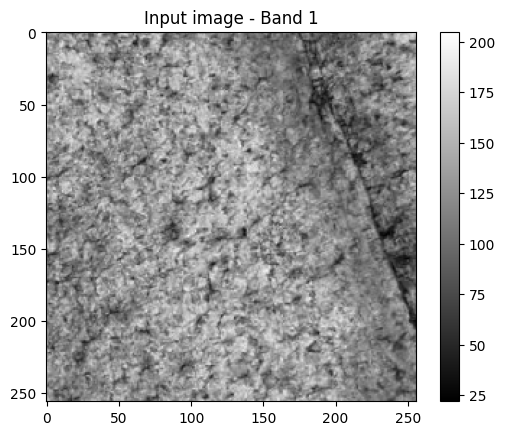

In [26]:
nth_band = 1  # Change this to select different bands
plt.figure()
plt.imshow(x[nth_band-1], cmap='gray')
plt.colorbar()
plt.title(f'Input image - Band {nth_band}')
plt.show()

### 1.2. Ground truth

In [27]:
y = xr.open_dataarray(yfolder + 'train/' + filename)
y

<xarray.DataArray 'band_data' (band: 1, y: 256, x: 256)> Size: 262kB
[65536 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * y            (y) float64 2kB -1.152 -1.153 -1.153 ... -1.279 -1.279 -1.28
  * x            (x) float64 2kB 0.128 0.1285 0.129 ... 0.2545 0.255 0.2555
    spatial_ref  int64 8B ...
Attributes:
    AREA_OR_POINT:  Area

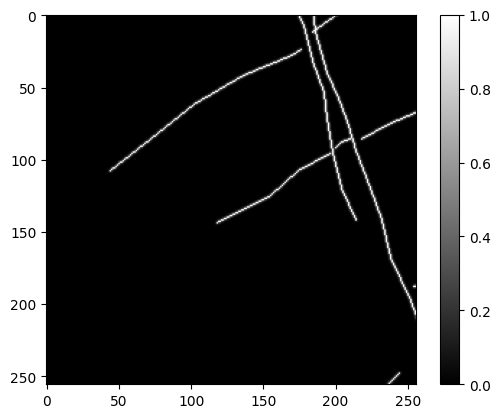

In [28]:
plt.figure()
plt.imshow(y[0], cmap='gray')
plt.colorbar()
plt.show()

### 1.3. Input - Ground Truth

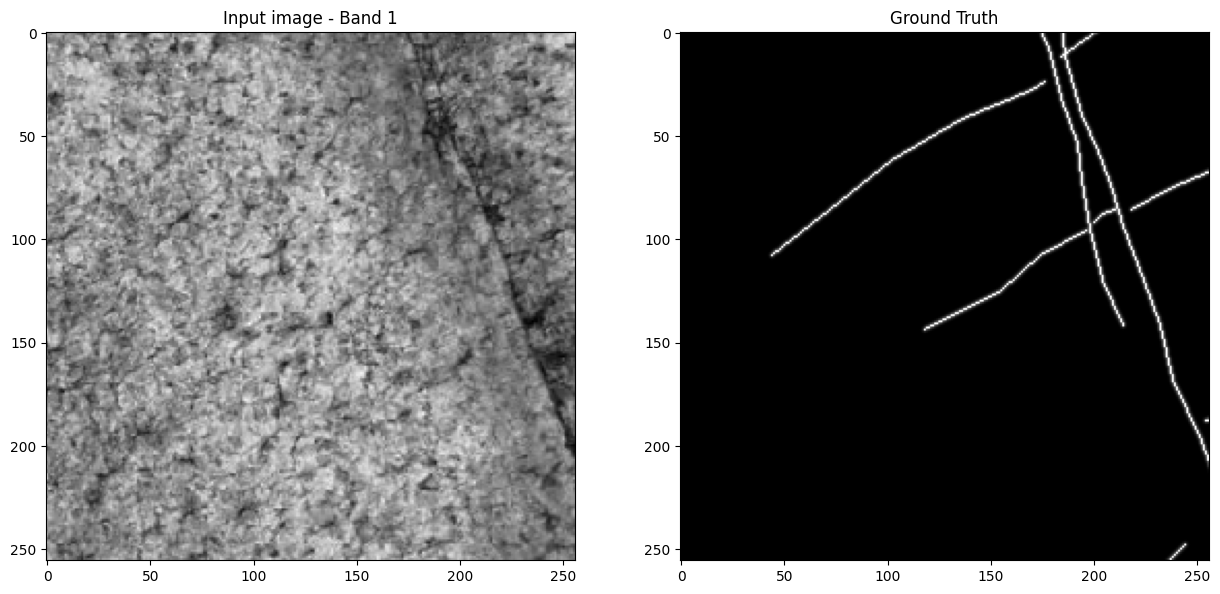

In [29]:
nth_band = 1  # Change this to select different bands

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 10))

ax0.imshow(x[nth_band-1], cmap='gray')
ax0.set_title(f'Input image - Band {nth_band}')
ax1.imshow(y[0], cmap='gray')
ax1.set_title('Ground Truth')
plt.show()

## 2. 1D or 3D input image data

In [30]:
filename = 'Site_A_798.tif'

In [31]:
input_channels = 3 # Set to 1 for grayscale, 3 for RGB

image = imread(xfolder + 'train/' + filename)
label = imread(yfolder + 'train/' + filename)

image = Image.fromarray(image[..., :3].astype(np.uint8))
image = image.convert("L") if input_channels == 1 else image.convert("RGB")

label = Image.fromarray((label * 255).astype(np.uint8)).convert("L")

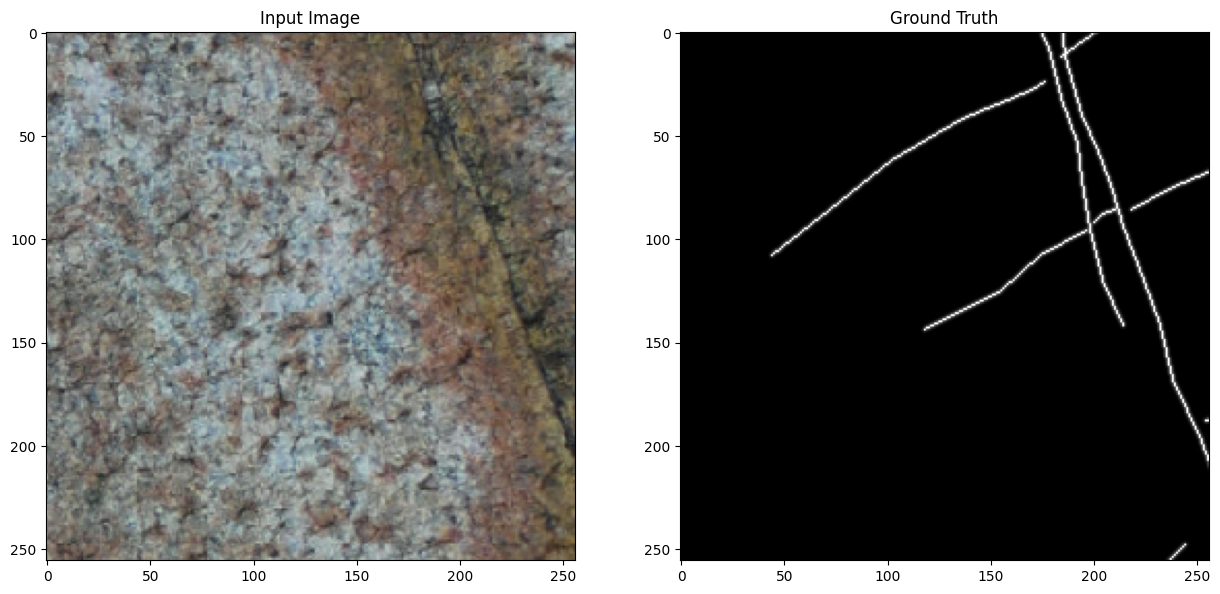

In [32]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 10))

ax0.imshow(image, cmap='gray') if input_channels == 1 else ax0.imshow(image)
ax0.set_title('Input Image')
ax1.imshow(label, cmap='gray')
ax1.set_title('Ground Truth')
plt.show()

## 3. Image transformation, Dataloaders and Data augmentation

In [42]:
# n_rotations = 4
# rotations = [i * (360 / n_rotations) for i in range(n_rotations)]  # [0, 90, 180, 270]
rotations = [0, 45, 90, 315]
# rotations = [0]

image_transform = faultMapping.image_transformation
label_transform = faultMapping.label_transformation

in_ch = 1  # Set to 1 for grayscale, 3 for RGB

train_set = faultMapping.faultMappingDataset(
    xfolder + 'train/', 
    yfolder + 'train/', 
    image_transform(), 
    label_transform(), 
    rotations=rotations, 
    every_n=2, 
    input_channels=in_ch
    )
val_set = faultMapping.faultMappingDataset(
    xfolder + 'val/', 
    yfolder + 'val/', 
    image_transform(), 
    label_transform(), 
    rotations=rotations, 
    every_n=2, 
    input_channels=in_ch
)
test_set = faultMapping.faultMappingDataset(
    xfolder + 'test/', 
    yfolder + 'test/', 
    image_transform(noise=False), 
    label_transform(noise=False), 
    rotations=[0], 
    every_n=1, 
    input_channels=in_ch
)

In [43]:
batch_size = 4
dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

image_datasets = {'train': train_set, 'val': val_set}
dataset_sizes = {x: len(image_datasets[x]) for x in image_datasets.keys()}
dataset_sizes

{'train': 4348, 'val': 648}

torch.Size([4, 1, 256, 256]) torch.Size([4, 1, 256, 256])


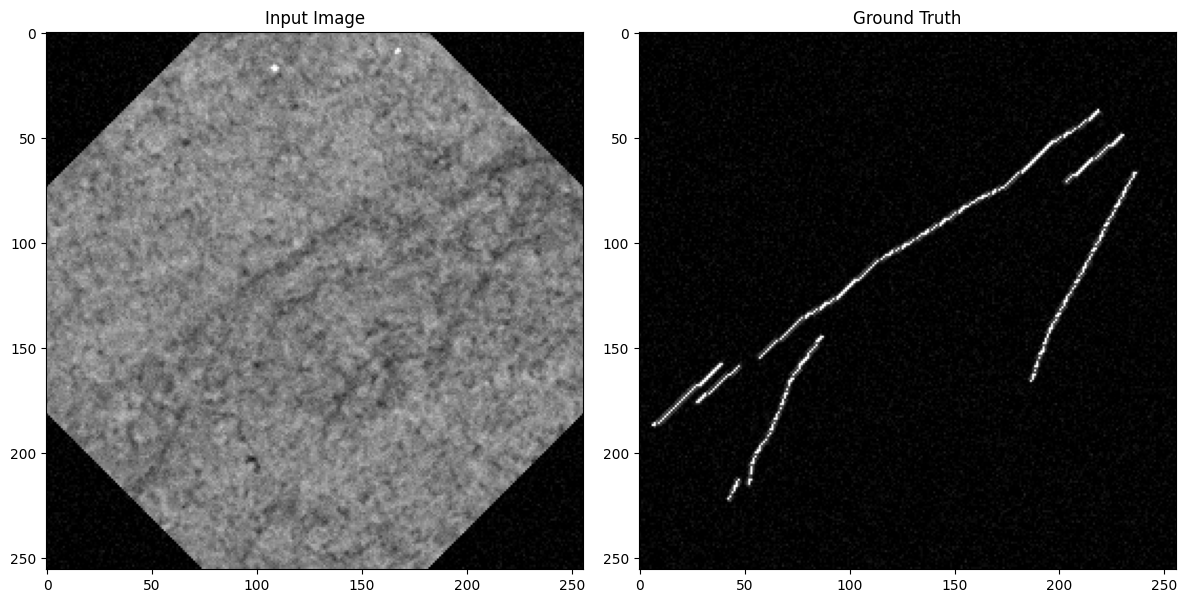

In [64]:
inputs, labels = next(iter(dataloaders['train']))
print(inputs.shape, labels.shape)

this_image = 2
plot_images.plot_input_gt(inputs[this_image], labels[this_image])